In [1]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, KFold
import nltk
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

In [2]:
hateval=pd.read_csv('hateval.tsv',sep='\t')
hateval_text=hateval['text']
hateval_text=hateval_text
#print(hateval_text)
hateval_label=hateval['label']
print('The number of imported tweets is:',len(hateval['text']))
print('The number of tweets containing hate speech is:',sum(hateval_label))

The number of imported tweets is: 9000
The number of tweets containing hate speech is: 3783


In [3]:
# take set of stopwords from nltk
stopwords=set(nltk.corpus.stopwords.words('english'))
#import string
#print(string.punctuation)
#adding extra punctuation into the stopwords library
stopwords.add("."), stopwords.add("..."), stopwords.add("#"), stopwords.add(","), stopwords.add("@"), stopwords.add(":")
stopwords.add(":)"), stopwords.add(":("), stopwords.add(";"), stopwords.add("--"), stopwords.add("``"), stopwords.add("’")
stopwords.add("n't"), stopwords.add("'s"), stopwords.add("''"), stopwords.add("'"), stopwords.add("-")
#print(stopwords)

(None, None, None, None, None)

In [4]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def token_maker(input):
    list_tokens=[]
    for index, row in input.iterrows():
      tweet_split=nltk.tokenize.sent_tokenize(row['text'])
      for tweet in tweet_split:
        tokens = nltk.tokenize.word_tokenize(tweet)
        for token in tokens:
          list_tokens.append(lemmatizer.lemmatize(token).lower())
    return(list_tokens)

In [5]:
def get_tokens(string):
    tweet_split=nltk.tokenize.sent_tokenize(string)
    list_tokens=[]
    for tweet in tweet_split:
      list_tokens_tweet=nltk.tokenize.word_tokenize(tweet)
      for token in list_tokens_tweet:
        list_tokens.append(lemmatizer.lemmatize(token).lower())
    return list_tokens

In [6]:
def sort_tokens(tokens, n):
    dict_word_freq={}
    for token in tokens:
        if token in stopwords: continue
        elif token not in dict_word_freq: dict_word_freq[token]=1
        else: dict_word_freq[token]+=1
    sorted_tokens = sorted(dict_word_freq.items(), key=lambda x: x[1], reverse=True)[:n]
    return(sorted_tokens)

In [7]:
def get_vocabulary(sorted_tokens):
    vocabulary=[]
    for word,frequency in sorted_tokens:
        vocabulary.append(word)
    return(np.asarray(vocabulary))

In [8]:
def get_features(input, vocabulary):
    features_array=[]
    for index, row in input.iterrows():
        tokens=get_tokens(row['text'])
        features=np.zeros(len(vocabulary))
        for i, word in enumerate(vocabulary):
            if word in tokens:
                features[i]=tokens.count(word)
        features_array.append(features)
    return np.asarray(features_array)

In [9]:
def train_svm_classifier(train, vocabulary):
    text_train = get_features(train, vocabulary)
    label_train = np.asarray(train['label'])
    svm_clf = sklearn.svm.SVC(kernel="linear",gamma='auto')
    svm_clf.fit(text_train,label_train)
    return(svm_clf)

In [ ]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

fold = 0        # set as all empty values to be filled
accuracy_total=0 # set as all empty values to be filled
precision_total=0 # set as all empty values to be filled
recall_total=0 # set as all empty values to be filled 
f_measure_total = 0.0 # set as all empty values to be filled

for train_index, test_index in kf.split(hateval): #the imported data 
    trainer = hateval.iloc[train_index]# split into a training data set and testing data set
    tester = hateval.iloc[test_index]
    
    tokens = token_maker(trainer)#calling the function to pre-process the data
    tokens_sorted = sort_tokens(tokens,25)
    vocab = get_vocabulary(tokens_sorted)#calling the function to get the 500 most common 'strings'
    svm_clf = train_svm_classifier(trainer, vocab)# SVM training the dataset 
    
    test_text = get_features(tester, vocab)
    test_label = np.asarray(tester['label'])
    label_test_predictions = svm_clf.predict(test_text)
    print(test_label)
    print(label_test_predictions)
    accuracy_fold=accuracy_score(test_label, label_test_predictions)
    f_measure_fold=f1_score(test_label, label_test_predictions)
    recall_fold=recall_score(test_label, label_test_predictions)
    precision_fold=precision_score(test_label, label_test_predictions)
    
    
    accuracy_total+=accuracy_fold
    precision_total+=precision_fold
    recall_total+=recall_fold
    f_measure_total+=f_measure_fold
    
    fold+=1
    print("\nFold "+str(fold)+"\n-----")
    print("Accuracy: "+str(round(accuracy_fold, 3)))
    print("Precision: "+str(round(precision_fold, 3)))
    print("Recall: "+str(round(recall_fold, 3)))
    print("F-measure: "+str(round(f_measure_fold, 3)))
    
average_accuracy=accuracy_total/10
average_precision=precision_total/10
average_recall=recall_total/10
average_f_measure=f_measure_total/10
print('The average Accuracy:',round(average_accuracy,3))
print('The average Precision:',round(average_precision,3))
print('The average Recall:',round(average_recall,3))
print('The average Recall:',round(average_f_measure,3))

[0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0
 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0
 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0
 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0
 0 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0
 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0
 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0
 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0
 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0
 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [37]:
print('The average Accuracy:',round(average_accuracy,3))
print('The average Precision:',round(average_precision,3))
print('The average Recall:',round(average_recall,3))
print('The average Recall:',round(average_f_measure,3))


The average Accuracy: 0.706
The average Precision: 0.745
The average Recall: 0.455
The average Recall: 0.565


In [32]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

fold = 0        # set as all empty values to be filled
accuracy_total=0 # set as all empty values to be filled
precision_total=0 # set as all empty values to be filled
recall_total=0 # set as all empty values to be filled 
f_measure_total = 0.0 # set as all empty values to be filled

for train_index, test_index in kf.split(hateval): #the imported data 
    trainer = hateval.iloc[train_index]# split into a training data set and testing data set
    tester = hateval.iloc[test_index]
    
    tokens = token_maker(trainer)#calling the function to pre-process the data
    tokens_sorted = sort_tokens(tokens,50)
    vocab = get_vocabulary(tokens_sorted)#calling the function to get the 500 most common 'strings'
    svm_clf = train_svm_classifier(trainer, vocab)# SVM training the dataset 
    
    test_text = get_features(tester, vocab)
    test_label = np.asarray(tester['label'])
    label_test_predictions = svm_clf.predict(test_text)
    
    accuracy_fold=accuracy_score(test_label, label_test_predictions)
    f_measure_fold=f1_score(test_label, label_test_predictions)
    recall_fold=recall_score(test_label, label_test_predictions)
    precision_fold=precision_score(test_label, label_test_predictions)
    
    
    accuracy_total+=accuracy_fold
    precision_total+=precision_fold
    recall_total+=recall_fold
    f_measure_total+=f_measure_fold
    
    fold+=1
    print("\nFold "+str(fold)+"\n-----")
    print("Accuracy: "+str(round(accuracy_fold, 3)))
    print("Precision: "+str(round(precision_fold, 3)))
    print("Recall: "+str(round(recall_fold, 3)))
    print("F-measure: "+str(round(f_measure_fold, 3)))
    
average_accuracy=accuracy_total/10
average_precision=precision_total/10
average_recall=recall_total/10
average_f_measure=f_measure_total/10
print('The average Accuracy:',round(average_accuracy,3))
print('The average Precision:',round(average_precision,3))
print('The average Recall:',round(average_recall,3))
print('The average Recall:',round(average_f_measure,3))


Fold 1
-----
Accuracy: 0.736
Precision: 0.762
Recall: 0.508
F-measure: 0.61

Fold 2
-----
Accuracy: 0.72
Precision: 0.781
Recall: 0.51
F-measure: 0.617

Fold 3
-----
Accuracy: 0.72
Precision: 0.726
Recall: 0.469
F-measure: 0.57

Fold 4
-----
Accuracy: 0.721
Precision: 0.756
Recall: 0.499
F-measure: 0.601

Fold 5
-----
Accuracy: 0.724
Precision: 0.748
Recall: 0.508
F-measure: 0.605

Fold 6
-----
Accuracy: 0.72
Precision: 0.777
Recall: 0.463
F-measure: 0.58

Fold 7
-----
Accuracy: 0.713
Precision: 0.748
Recall: 0.457
F-measure: 0.567

Fold 8
-----
Accuracy: 0.719
Precision: 0.786
Recall: 0.494
F-measure: 0.607

Fold 9
-----
Accuracy: 0.72
Precision: 0.72
Recall: 0.497
F-measure: 0.588

Fold 10
-----
Accuracy: 0.722
Precision: 0.801
Recall: 0.514
F-measure: 0.626
The average Accuracy: 0.722
The average Precision: 0.76
The average Recall: 0.492
The average Recall: 0.597


In [33]:
kf = KFold(n_splits=10, random_state=40, shuffle=True)

fold = 0        # set as all empty values to be filled
accuracy_total=0 # set as all empty values to be filled
precision_total=0 # set as all empty values to be filled
recall_total=0 # set as all empty values to be filled 
f_measure_total = 0.0 # set as all empty values to be filled

for train_index, test_index in kf.split(hateval): #the imported data 
    trainer = hateval.iloc[train_index]# split into a training data set and testing data set
    tester = hateval.iloc[test_index]
    
    tokens = token_maker(trainer)#calling the function to pre-process the data
    tokens_sorted = sort_tokens(tokens,100)
    vocab = get_vocabulary(tokens_sorted)#calling the function to get the 500 most common 'strings'
    svm_clf = train_svm_classifier(trainer, vocab)# SVM training the dataset 
    
    test_text = get_features(tester, vocab)
    test_label = np.asarray(tester['label'])
    label_test_predictions = svm_clf.predict(test_text)
    
    accuracy_fold=accuracy_score(test_label, label_test_predictions)
    f_measure_fold=f1_score(test_label, label_test_predictions)
    recall_fold=recall_score(test_label, label_test_predictions)
    precision_fold=precision_score(test_label, label_test_predictions)
    
    
    accuracy_total+=accuracy_fold
    precision_total+=precision_fold
    recall_total+=recall_fold
    f_measure_total+=f_measure_fold
    
    fold+=1
    print("\nFold "+str(fold)+"\n-----")
    print("Accuracy: "+str(round(accuracy_fold, 3)))
    print("Precision: "+str(round(precision_fold, 3)))
    print("Recall: "+str(round(recall_fold, 3)))
    print("F-measure: "+str(round(f_measure_fold, 3)))
    
average_accuracy=accuracy_total/10
average_precision=precision_total/10
average_recall=recall_total/10
average_f_measure=f_measure_total/10
print('The average Accuracy:',round(average_accuracy,3))
print('The average Precision:',round(average_precision,3))
print('The average Recall:',round(average_recall,3))
print('The average Recall:',round(average_f_measure,3))


Fold 1
-----
Accuracy: 0.748
Precision: 0.756
Recall: 0.56
F-measure: 0.644

Fold 2
-----
Accuracy: 0.746
Precision: 0.801
Recall: 0.565
F-measure: 0.663

Fold 3
-----
Accuracy: 0.742
Precision: 0.746
Recall: 0.528
F-measure: 0.618

Fold 4
-----
Accuracy: 0.738
Precision: 0.77
Recall: 0.538
F-measure: 0.634

Fold 5
-----
Accuracy: 0.746
Precision: 0.756
Recall: 0.572
F-measure: 0.651

Fold 6
-----
Accuracy: 0.733
Precision: 0.774
Recall: 0.511
F-measure: 0.615

Fold 7
-----
Accuracy: 0.738
Precision: 0.756
Recall: 0.535
F-measure: 0.627

Fold 8
-----
Accuracy: 0.74
Precision: 0.795
Recall: 0.549
F-measure: 0.65

Fold 9
-----
Accuracy: 0.734
Precision: 0.727
Recall: 0.544
F-measure: 0.622

Fold 10
-----
Accuracy: 0.737
Precision: 0.801
Recall: 0.555
F-measure: 0.656
The average Accuracy: 0.74
The average Precision: 0.768
The average Recall: 0.546
The average Recall: 0.638


In [34]:
kf = KFold(n_splits=10, random_state=40, shuffle=True)

fold = 0        # set as all empty values to be filled
accuracy_total=0 # set as all empty values to be filled
precision_total=0 # set as all empty values to be filled
recall_total=0 # set as all empty values to be filled 
f_measure_total = 0.0 # set as all empty values to be filled

for train_index, test_index in kf.split(hateval): #the imported data 
    trainer = hateval.iloc[train_index]# split into a training data set and testing data set
    tester = hateval.iloc[test_index]
    
    tokens = token_maker(trainer)#calling the function to pre-process the data
    tokens_sorted = sort_tokens(tokens,300)
    vocab = get_vocabulary(tokens_sorted)#calling the function to get the 500 most common 'strings'
    svm_clf = train_svm_classifier(trainer, vocab)# SVM training the dataset 
    
    test_text = get_features(tester, vocab)
    test_label = np.asarray(tester['label'])
    label_test_predictions = svm_clf.predict(test_text)
    
    accuracy_fold=accuracy_score(test_label, label_test_predictions)
    f_measure_fold=f1_score(test_label, label_test_predictions)
    recall_fold=recall_score(test_label, label_test_predictions)
    precision_fold=precision_score(test_label, label_test_predictions)
    
    
    accuracy_total+=accuracy_fold
    precision_total+=precision_fold
    recall_total+=recall_fold
    f_measure_total+=f_measure_fold
    
    fold+=1
    print("\nFold "+str(fold)+"\n-----")
    print("Accuracy: "+str(round(accuracy_fold, 3)))
    print("Precision: "+str(round(precision_fold, 3)))
    print("Recall: "+str(round(recall_fold, 3)))
    print("F-measure: "+str(round(f_measure_fold, 3)))
    
average_accuracy=accuracy_total/10
average_precision=precision_total/10
average_recall=recall_total/10
average_f_measure=f_measure_total/10
print('The average Accuracy:',round(average_accuracy,3))
print('The average Precision:',round(average_precision,3))
print('The average Recall:',round(average_recall,3))
print('The average Recall:',round(average_f_measure,3))


Fold 1
-----
Accuracy: 0.788
Precision: 0.773
Recall: 0.678
F-measure: 0.722

Fold 2
-----
Accuracy: 0.779
Precision: 0.835
Recall: 0.623
F-measure: 0.714

Fold 3
-----
Accuracy: 0.788
Precision: 0.792
Recall: 0.629
F-measure: 0.701

Fold 4
-----
Accuracy: 0.773
Precision: 0.811
Recall: 0.602
F-measure: 0.691

Fold 5
-----
Accuracy: 0.776
Precision: 0.774
Recall: 0.65
F-measure: 0.706

Fold 6
-----
Accuracy: 0.771
Precision: 0.795
Recall: 0.609
F-measure: 0.69

Fold 7
-----
Accuracy: 0.759
Precision: 0.756
Recall: 0.611
F-measure: 0.676

Fold 8
-----
Accuracy: 0.766
Precision: 0.803
Recall: 0.618
F-measure: 0.698

Fold 9
-----
Accuracy: 0.758
Precision: 0.732
Recall: 0.627
F-measure: 0.676

Fold 10
-----
Accuracy: 0.768
Precision: 0.809
Recall: 0.636
F-measure: 0.713
The average Accuracy: 0.772
The average Precision: 0.788
The average Recall: 0.628
The average Recall: 0.699


In [35]:
kf = KFold(n_splits=10, random_state=40, shuffle=True)

fold = 0        # set as all empty values to be filled
accuracy_total=0 # set as all empty values to be filled
precision_total=0 # set as all empty values to be filled
recall_total=0 # set as all empty values to be filled 
f_measure_total = 0.0 # set as all empty values to be filled

for train_index, test_index in kf.split(hateval): #the imported data 
    trainer = hateval.iloc[train_index]# split into a training data set and testing data set
    tester = hateval.iloc[test_index]
    
    tokens = token_maker(trainer)#calling the function to pre-process the data
    tokens_sorted = sort_tokens(tokens,750)
    vocab = get_vocabulary(tokens_sorted)#calling the function to get the 500 most common 'strings'
    svm_clf = train_svm_classifier(trainer, vocab)# SVM training the dataset 
    
    test_text = get_features(tester, vocab)
    test_label = np.asarray(tester['label'])
    label_test_predictions = svm_clf.predict(test_text)
    
    accuracy_fold=accuracy_score(test_label, label_test_predictions)
    f_measure_fold=f1_score(test_label, label_test_predictions)
    recall_fold=recall_score(test_label, label_test_predictions)
    precision_fold=precision_score(test_label, label_test_predictions)
    
    
    accuracy_total+=accuracy_fold
    precision_total+=precision_fold
    recall_total+=recall_fold
    f_measure_total+=f_measure_fold
    
    fold+=1
    print("\nFold "+str(fold)+"\n-----")
    print("Accuracy: "+str(round(accuracy_fold, 3)))
    print("Precision: "+str(round(precision_fold, 3)))
    print("Recall: "+str(round(recall_fold, 3)))
    print("F-measure: "+str(round(f_measure_fold, 3)))
    
average_accuracy=accuracy_total/10
average_precision=precision_total/10
average_recall=recall_total/10
average_f_measure=f_measure_total/10
print('The average Accuracy:',round(average_accuracy,3))
print('The average Precision:',round(average_precision,3))
print('The average Recall:',round(average_recall,3))
print('The average Recall:',round(average_f_measure,3))


Fold 1
-----
Accuracy: 0.781
Precision: 0.744
Recall: 0.705
F-measure: 0.724

Fold 2
-----
Accuracy: 0.766
Precision: 0.781
Recall: 0.653
F-measure: 0.711

Fold 3
-----
Accuracy: 0.79
Precision: 0.767
Recall: 0.674
F-measure: 0.717

Fold 4
-----
Accuracy: 0.764
Precision: 0.77
Recall: 0.628
F-measure: 0.692

Fold 5
-----
Accuracy: 0.766
Precision: 0.738
Recall: 0.676
F-measure: 0.706

Fold 6
-----
Accuracy: 0.772
Precision: 0.777
Recall: 0.638
F-measure: 0.701

Fold 7
-----
Accuracy: 0.754
Precision: 0.738
Recall: 0.624
F-measure: 0.676

Fold 8
-----
Accuracy: 0.771
Precision: 0.789
Recall: 0.653
F-measure: 0.715

Fold 9
-----
Accuracy: 0.747
Precision: 0.693
Recall: 0.666
F-measure: 0.679

Fold 10
-----
Accuracy: 0.782
Precision: 0.802
Recall: 0.688
F-measure: 0.741
The average Accuracy: 0.769
The average Precision: 0.76
The average Recall: 0.661
The average Recall: 0.706


Text(0, 0.5, 'F-measure of algorithm')

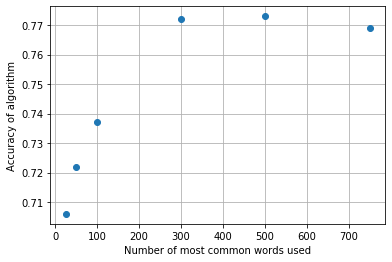

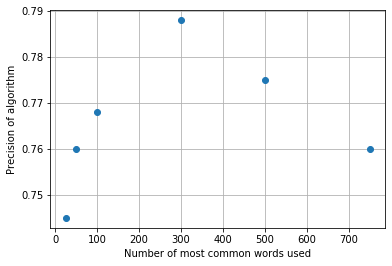

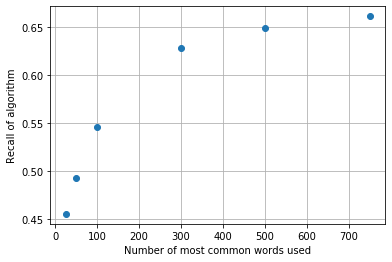

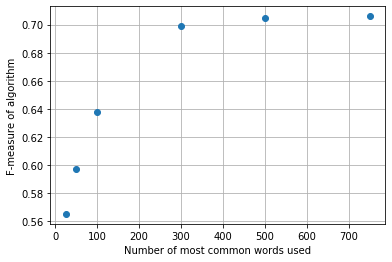

In [46]:
import matplotlib.pyplot as plt
x=np.array([25,50,100,300,500,750])
plt.figure(1)
y_accuracy=np.array([0.706,0.722,0.737, 0.772,0.773,0.769])
plt.plot(x,y_accuracy,'o')
plt.grid()
plt.xlabel('Number of most common words used')
plt.ylabel('Accuracy of algorithm')
plt.figure(2)
y_precision=np.array([0.745,0.76,0.768,0.788,0.775,0.76])
plt.plot(x,y_precision,'o')
plt.grid()
plt.xlabel('Number of most common words used')
plt.ylabel('Precision of algorithm')
plt.figure(3)
y_recall=np.array([0.455,0.492,0.546,0.628,0.649,0.661])
plt.plot(x,y_recall,'o')
plt.grid()
plt.xlabel('Number of most common words used')
plt.ylabel('Recall of algorithm')
plt.figure(4)
y_f_score=np.array([0.565,0.597,0.638,0.699,0.705,0.706])
plt.plot(x,y_f_score,'o')
plt.grid()
plt.xlabel('Number of most common words used')
plt.ylabel('F-measure of algorithm')
